In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import TensorDataset,random_split,Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [22]:
!pip install scikit-optimize

In [4]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import *
from skopt.utils import use_named_args

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

In [6]:
class SignLanguageDataSet(Dataset):
    """ sign language dataset"""

    def __init__(self, X, Y, onehot=True):
        """
        :param X: numpy.array
        :param Y: numpy.array
        """
        X = X.reshape((-1, 1, 64, 64))  # we need to add a channel, so we can use convolution
        if onehot:  # the Y from npy is onehot-encoded, need to convert to interger
            Y = np.argmax(Y, axis=1)

        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        X = self.X[idx]
        Y = self.Y[idx]

        sample = {'X': X, 'Y': Y}
        return sample

Y = np.load('Y.npy')
X = np.load('X.npy')


x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

trainSignData = SignLanguageDataSet(x_train, y_train, onehot=True)
trainDataLoader = DataLoader(trainSignData, shuffle=True, batch_size=32)

testSignData = SignLanguageDataSet(x_test, y_test, onehot=True)
testDataLoader = DataLoader(testSignData, shuffle=False, batch_size=32)

In [7]:
class Net(nn.Module):
    def __init__(self,l1,l2,l3,l4):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=9)  # 60 * 60
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=7)  #
        self.fc1   = nn.Linear(11*11*6, l1)
        self.fc2   = nn.Linear(l1, l2)
        self.fc3   = nn.Linear(l2, l3)
        self.fc4   = nn.Linear(l3, l4)
        self.fc5   = nn.Linear(l4, 10)

    def forward(self, x,activation):
        if activation=="relu":
            out = F.relu(self.conv1(x))  # None * 3 * 56 * 56
            out = F.max_pool2d(out, 2)  # None * 3 * 28 * 28
            out = F.relu(self.conv2(out))  # None * 6 * 22 * 22
            out = F.max_pool2d(out, 2)    # None * 6 * 11 * 11
            out = out.view(out.size(0), -1)  #
            out = F.relu(self.fc1(out))
            out = F.relu(self.fc2(out))
            out = F.relu(self.fc3(out))
            out = F.relu(self.fc4(out))
            out = self.fc5(out)
        else:
            out = F.tanh(self.conv1(x))  # None * 3 * 56 * 56
            out = F.max_pool2d(out, 2)  # None * 3 * 28 * 28
            out = F.tanh(self.conv2(out))  # None * 6 * 22 * 22
            out = F.max_pool2d(out, 2)    # None * 6 * 11 * 11
            out = out.view(out.size(0), -1)  #
            out = F.tanh(self.fc1(out))
            out = F.tanh(self.fc2(out))
            out = F.tanh(self.fc3(out))
            out = F.tanh(self.fc4(out))
            out = self.fc5(out)
        return out

In [8]:
criterion = nn.CrossEntropyLoss()
def train(net,epoch,activation):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, sample in enumerate(trainDataLoader):
        optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
        optimizer.zero_grad()
        inputs, targets = Variable(sample['X']), Variable(sample['Y'])
        outputs = net(inputs,activation)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
    return(net)

def test(net,activation):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, sample in enumerate(testDataLoader):
        inputs, targets = Variable(sample['X'], volatile=True), Variable(sample['Y'])
        outputs = net(inputs,activation)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()
        return(test_loss)

In [9]:
activation = Categorical(categories=['relu', 'tanh'], name='activation') #custom data type with format as ([],"")
l1 = Integer(low=10, high=500, name='l1')
l2 = Integer(low=10, high=500, name='l2')
l3 = Integer(low=10, high=500, name='l3')
l4 = Integer(low=10, high=500, name='l4')
dimension=[activation,l1,l2,l3,l4]
x0 = ["relu",120,359,251,104]

In [10]:
@use_named_args(dimensions=dimension)
def fitness(activation, l1, l2, l3, l4):



    print('activation:',activation)
    print('Number of nodes in second linear layer :', l1)
    print('Number of nodes in third linear layer:', l2)
    print('Number of nodes in fourth linear layer:', l3)
    print('Number of nodes in fifth linear layer:', l4)
    print()

    # Create the neural network with these hyper-parameters.
    net = Net(l1,l2,l3,l4)
    for epoch in range(25):
        net = train(net,epoch,activation)
    loss = test(net,activation)
    return loss

In [31]:
res = gp_minimize(func = fitness,                  # the function to minimize
                  dimensions = dimension,
                  acq_func="EI",      # the acquisition function = EI(x)=E[max(fmin−f(x),0)]
                  n_calls=25,         # the number of evaluations
                  noise=0.1**2, # the noise level (optional)
                  x0 = ["relu",120,359,251,104],
                  random_state=1234)   # the random seed

activation: relu
Number of nodes in second linear layer : 120
Number of nodes in third linear layer: 359
Number of nodes in fourth linear layer: 251
Number of nodes in fifth linear layer: 104

activation: relu
Number of nodes in second linear layer : 411
Number of nodes in third linear layer: 310
Number of nodes in fourth linear layer: 388
Number of nodes in fifth linear layer: 432

activation: relu
Number of nodes in second linear layer : 107
Number of nodes in third linear layer: 409
Number of nodes in fourth linear layer: 88
Number of nodes in fifth linear layer: 67

activation: relu
Number of nodes in second linear layer : 249
Number of nodes in third linear layer: 172
Number of nodes in fourth linear layer: 403
Number of nodes in fifth linear layer: 58

activation: relu
Number of nodes in second linear layer : 227
Number of nodes in third linear layer: 21
Number of nodes in fourth linear layer: 152
Number of nodes in fifth linear layer: 131

activation: tanh
Number of nodes in sec

In [32]:
print('optimal hyper-parameters')
print()
print(f'activation: {res.x[0]}')
print(f'Number of nodes in second linear layer: {res.x[1]}')
print(f'Number of nodes in third linear layer: {res.x[2]}')
print(f'Number of nodes in fourth linear layer: {res.x[3]}')
print(f'Number of nodes in fifth linear layer: {res.x[4]}')

optimal hyper-parameters

activation: tanh
Number of nodes in second linear layer: 324
Number of nodes in third linear layer: 10
Number of nodes in fourth linear layer: 500
Number of nodes in fifth linear layer: 500


In [33]:
pd.DataFrame((zip(res.func_vals, res.x_iters)), index=np.arange(25), columns=['score', 'params'])

,score,params
0,2.300224,"[relu, 120, 359, 251, 104]"
1,2.296616,"[relu, 411, 310, 388, 432]"
2,2.295051,"[relu, 107, 409, 88, 67]"
3,2.293111,"[relu, 249, 172, 403, 58]"
4,2.297925,"[relu, 227, 21, 152, 131]"
5,2.282217,"[tanh, 446, 494, 68, 203]"
6,2.297945,"[relu, 274, 397, 238, 223]"
7,2.271318,"[tanh, 485, 30, 279, 237]"
8,2.297123,"[relu, 171, 409, 327, 33]"
9,2.222610,"[tanh, 348, 465, 460, 488]"


<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

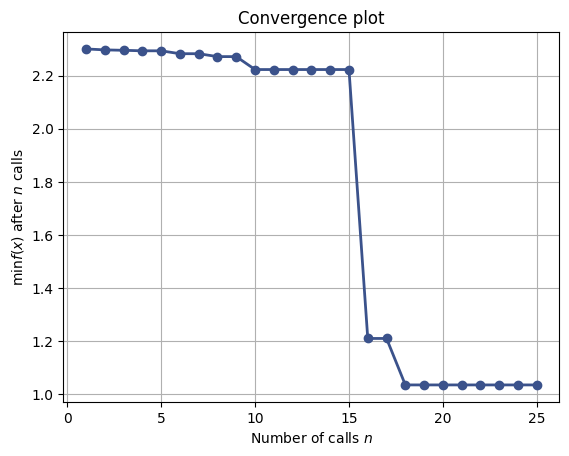

In [34]:
%matplotlib inline
plot_convergence(res)

In [ ]:
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
import time

# Define custom scorer
def custom_scorer(estimator, X, y):
    loss = estimator(X, y)
    return -loss  # GridSearchCV minimizes the score, so we negate the loss

# Wrapper function for compatibility with GridSearchCV
def wrapper(activation, l1, l2, l3, l4):
    start_time = time.time()
    loss = fitness(activation, l1, l2, l3, l4)
    end_time = time.time()
    print("Time taken:", end_time - start_time, "seconds")
    return loss

# Define hyperparameter space
param_grid = {
    'activation': ['relu', 'tanh'],
    'l1': range(10, 51),
    'l2': range(10, 51),
    'l3': range(10, 51),
    'l4': range(10, 51)
}
from sklearn.base import BaseEstimator

class WrapperEstimator(BaseEstimator):
    def __init__(self, activation, l1, l2, l3, l4):
        self.activation = activation
        self.l1 = l1
        self.l2 = l2
        self.l3 = l3
        self.l4 = l4

    def fit(self, X, y):
        # Fit method is not required, as we perform training in the custom scoring function
        pass

    def score(self, X, y):
        # Call the fitness function with the specified hyperparameters
        return fitness(self.activation, self.l1, self.l2, self.l3, self.l4)

    def get_params(self, deep=True):
        return {
            'activation': self.activation,
            'l1': self.l1,
            'l2': self.l2,
            'l3': self.l3,
            'l4': self.l4
        }

# Create an instance of the wrapper estimator
wrapper_estimator = WrapperEstimator('relu', 12, 35, 25, 10)

# Now you can use GridSearchCV with the wrapper estimator
grid_search = GridSearchCV(estimator=wrapper_estimator, param_grid=param_grid, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X, Y)  # Assuming X and Y are defined and loaded appropriately

# Print best parameters and corresponding loss
print("Best parameters:", grid_search.best_params_)
print("Best loss:", grid_search.best_score_)